# 15 LoopStack

In [1]:
# default_exp loopstack

In [2]:
# export
from forgebox.loop import Loop,ProgressBar,Tolerate,Event,Stuff,chunkify
from types import MethodType
import numpy as np

To run through iterations quickly, we use the california housing data

In [3]:
from sklearn.datasets.california_housing import fetch_california_housing
x,y = fetch_california_housing(return_X_y = True)

x.shape, y.shape

((20640, 8), (20640,))

Normalized Data

Preview x input

In [4]:
def norm(m,s): return lambda x: (x-m)/s
def denorm(m,s): return lambda x: (x*s)+m

x_normed = norm(x.mean(0),x.std(0))(x)
y_normed = norm(y.mean(),y.std())(y)

In [5]:
x_normed.mean(0).astype(np.float16),x_normed.std(0),\
y_normed.mean().astype(np.float16),y_normed.std()

(array([ 0.,  0.,  0., -0., -0.,  0., -0., -0.], dtype=float16),
 array([1., 1., 1., 1., 1., 1., 1., 1.]),
 0.0,
 1.0)

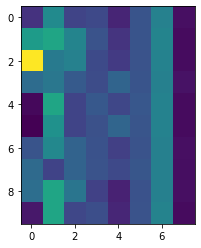

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(x_normed[np.random.choice(range(1000),10)])

In [7]:
x_normed

array([[ 2.34476576,  0.98214266,  0.62855945, ..., -0.04959654,
         1.05254828, -1.32783522],
       [ 2.33223796, -0.60701891,  0.32704136, ..., -0.09251223,
         1.04318455, -1.32284391],
       [ 1.7826994 ,  1.85618152,  1.15562047, ..., -0.02584253,
         1.03850269, -1.33282653],
       ...,
       [-1.14259331, -0.92485123, -0.09031802, ..., -0.0717345 ,
         1.77823747, -0.8237132 ],
       [-1.05458292, -0.84539315, -0.04021111, ..., -0.09122515,
         1.77823747, -0.87362627],
       [-0.78012947, -1.00430931, -0.07044252, ..., -0.04368215,
         1.75014627, -0.83369581]])

In [8]:
# export
def create_event(event_name):
    class BatchEvent(Event):pass
    BatchEvent.__name__ = event_name
    return BatchEvent

def events(*enames):
    return list(map(create_event,enames))

In [9]:
# export
class LoopStack(Loop):
    settings = []
    """
    A stack of loop
    """
    @classmethod
    def from_loops(cls,*loops):
        def init(self,iterable=[],name = None):
            name = name if name!=None else cls.__name__
            
            self.loops = dict()
            l = Loop(iterable)
            for L in loops:
                l = L(iterable = l)
            super().__init__(iterable = l,
                             name = name)
            
            for stuff in cls.settings:
                self.make_stuff(stuff)
                
            
            
        setattr(cls,"init",init)
        return cls
    
    @classmethod
    def new_setting(cls,*settings):
        cls.settings+=list(settings)
    
    def make_stuff(self,name):
        new_stuff = Stuff(name)
        setattr(self.core,name,new_stuff)
        setattr(self,name,new_stuff)
    
    def __repr__(self,):
        return f"LoopStack>:{self.name}\n\t"+\
            "\n\t".join(map(str,self.core.layers[:-1]))

In [10]:
TRAIN_EVENTS = ["DATA_PROCESS","FORWARD","LOSS_CALC",
                "BACKWARD","OPT_STEP","METRICS"]
EVAL_EVENTS = ["DATA_PROCESS","EVAL_WRAP","FORWARD","LOSS_CALC","METRICS"]

In [43]:
# export 
import torch
from torch import is_tensor

def train_callbacks(loop):
    @loop.on_DATA_PROCESS
    def opt_zero_grad(loop):
        loop.opt("zero_grad")
        
    @loop.before_1st_FORWARD
    def switch_model_to_train(loop):
        loop.model("train")
        
    @loop.BACKWARD.on
    def opt_step(loop):
        loop.loss("backward")
            
    @loop.BACKWARD.on
    def opt_step(loop):
        loop.opt("step")
        
def to_tensor(x):
    return torch.Tensor(x)
        
def train_single_forward(metric_func = []):
    def train_single_forward_cb(self):
        @self.on_DATA_PROCESS
        def set_xy(self):
            self.var.x,self.var.y = self.element
            self.var.x = to_tensor(self.var.x)
            self.var.y = to_tensor(self.var.y)
            
        @self.on_FORWARD
        def forward_pass(self):
            y_ = self.model("__call__",self.var.x)
            self.var.y_ = y_.popitem()[1][:,0]
            
        @self.on_LOSS_CALC
        def calculate_loss(self):
            for loss_name,loss_val in \
                self.loss_func("__call__",self.var.y_,self.var.y).items():
                self.loss[loss_name] = loss_val
            
        @self.on_METRICS
        def calcualte_metrics(self):
            # calculate metrics
            with torch.no_grad():
                self.metric.cases.update(self.metric_func("__call__",
                                                          self.var.y_,self.var.y))
        
        @self.on_METRICS
        def to_item(self):
            # loop through metrics
            dt = self.metric.cases
            dt.update(self.loss.cases)
            dt = dict((k,v.item() if is_tensor(v) else v) \
                          for k,v in dt.items())
            self.results.append(dt)
            self.pgbar_data(dt)
            
    return train_single_forward_cb

def single_device(device):
    def single_device_callback(self):
        @on_DATA_PROCESS
        def var_to_device(self):
            self.var.update("to",device)
            
        @before_1st_FORWARD
        def model_to_device(self):
            self.model.update("to",device)
            
    return single_device
    
class TrainLoop(LoopStack):
    def __init__(self,data_iter,model=[],opt=[],loss_func=[],loss=[],hp=[],cuda=[], 
                 callbacks = [train_callbacks,],tolerate=True):
        loops = [ProgressBar,]
        if tolerate:
            loops.append(Tolerate)
        loops+=list(events(*TRAIN_EVENTS))
        self.from_loops(*loops)
        self.new_setting("model","var",
                         "opt","loss_func","loss",
                         "hp","cuda","metric_func","metric")
        self.init(data_iter,)
        for cb in callbacks:
            print(f"assigning callback {cb}")
            cb(self)
            
        self.core.results = []
        
class EvalLoop(LoopStack):
    def __init__(self,data_iter,tolerate=True):
        loops = [ProgressBar,]
        if tolerate:
            loops.append(Tolerate)
        loops+=list(events(*EVAL_EVENTS))
        self.from_loops(*loops)
        self.new_setting("model","var",
                         "loss_func","loss",
                         "hp","cuda","metric_func","metric")
        self.__init__(data_iter,)
        
        @self.EVAL_FORWARD.downstream
        def torch_eval_wrap(self,func):
            with torch.no_grad():
                func()

In [72]:
from torch import nn
import torch

data_list = list(zip(chunkify(x_normed),chunkify(y_normed)))

loop = TrainLoop(data_list,tolerate=False,
                 callbacks=[train_callbacks,
                            train_single_forward([nn.MSELoss()])])
loop

assigning callback <function train_callbacks at 0x1a2f9b43b0>
assigning callback <function train_single_forward.<locals>.train_single_forward_cb at 0x1a32c8d440>


LoopStack>:TrainLoop
	layer🍰Loop
	layer🍰ProgressBar
	event🌏DATA_PROCESS
	event🌏FORWARD
	event🌏LOSS_CALC
	event🌏BACKWARD
	event🌏OPT_STEP
	event🌏METRICS

In [73]:
# loop.search()

In [75]:
loop.model.baseline = nn.Linear(8,1)
loop.loss_func.mse = torch.nn.MSELoss()
loop.metric_func.mae = torch.nn.L1Loss()
loop.opt.adam = torch.optim.Adam(loop.model.baseline.parameters())

In [76]:
for i in range(8):loop.run()

In [56]:
import pandas as pd
pd.DataFrame(loop.results)

,mae,mse
0,0.838709,1.321269
1,0.676079,0.593617
2,0.875658,0.955391
3,1.093525,1.841254
4,1.884628,4.300918
...,...,...
5155,0.365038,0.177207
5156,0.503200,0.411286
5157,0.391761,0.211094
5158,0.420467,0.235614


In [57]:
from matplotlib import pyplot as plt

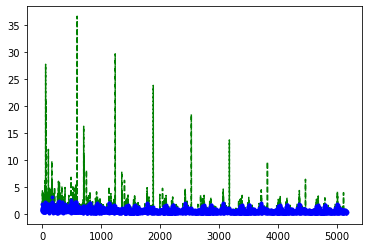

In [61]:
plt.plot(pd.DataFrame(loop.results).mse,"g--",pd.DataFrame(loop.results).mae,"b.")

In [62]:
loop.model

🍄:model[
	baseline
]

In [63]:
loop.loss_func

🍄:loss_func[
	mse
]

In [67]:
loop.metric

🍄:metric[
	mae
	mse
]

In [70]:
loop.metric.mse

tensor(0.1766, grad_fn=<MseLossBackward>)